# Etude d'un laminé non-linéaire

In [1]:
# Enlever les  # pour que les figures s'ouvrent dans une fenêtre interactive à part

import numpy as np
#%matplotlib qt5
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D
#plt.ion()

On étudie le matériau homogénéisé suivant (laminé d'ordre 1), qu'on suppose non-linéaire et muni des axes $d$ et $q$ précisés sur la figure ci-dessous :
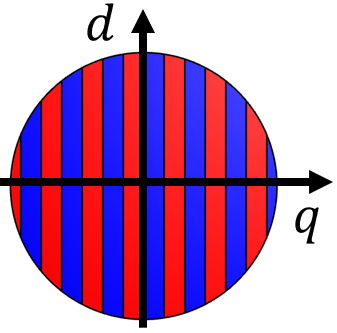
La fraction volumique du fer (en rouge) pourra varier, tout comme la valeur du champ moyen dans les axes $d$ et $q$.

## 1) Définition du matériau non-linéaire
On propose le modèle suivant, qui prend en entrée la norme du champ magnétique $h$ et renvoie en sortie la norme de l'induction $b$. :

$$ b(h) = \mu_0 \left[2\mu_{r0} - \left( \frac{\arctan(h/h_s)}{\pi} +0.5 \right)(2\mu_{r0} -1) \right] h$$

Qui dépend des paramètres suivants :
- $\mu_{r0}>1$ : perméabilité relative initiale approximative
- $h_s$ : champ magnétique approximatif au coude de saturation

On propose par exemple le modèle associé à une courbe BH de ferrite douce:

In [2]:
mu_r0 = 1000
hsat = 3e6/mu_r0
mu0 = 4e-7*np.pi

def b(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return mu0*(2*mu_r0*h-(np.arctan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )
    return mu0*(2*mu_r0*h-(atan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )

def dbdh(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return -mu0*(((2*mu_r0 - 1)*(np.pi + 2*np.arctan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))
    return -mu0*(((2*mu_r0 - 1)*(np.pi + 2*atan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))

def mu(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return mu0 + (b(h)/h-mu0)*rho

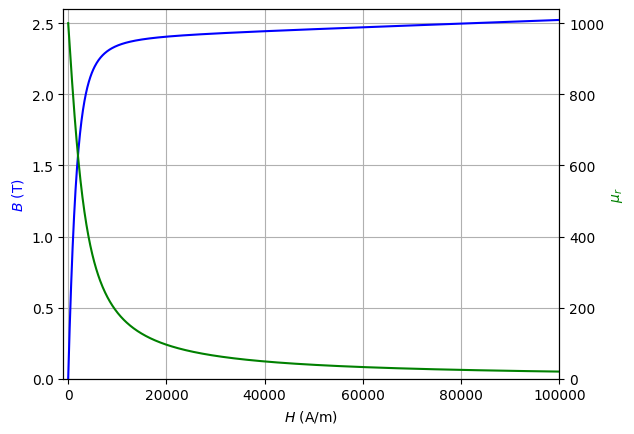

In [3]:
# Tracé
H = np.linspace(1e-6,1e5,1000)
fig, ax1 = plt.subplots()
plt.grid()
ax2 = ax1.twinx()
ax1.plot(H,b(H), 'b-') ; ax2.plot(H,b(H)/H/mu0, 'g-')

ax1.axis([-1000,1e5,0,2.6]) ;
ax1.set_xlabel('$H$ (A/m)') ; ax1.set_ylabel('$B$ (T)', color='b')
ax2.set_ylabel('$\mu_r$', color='g') ; ax2.axis([-1000,1e5,0,1040])
plt.show()

## 2) Champ dans l'axe $q$

Dans l'axe $q$, les matériaux sont en *série*. Comme on impose un flux homogène sur les bords orientés dans l'axe $q$, l'induction est homogène et égale au champ moyen $\beta$, comme l'illustre la figure ci-dessous pour $\beta = 1T$.

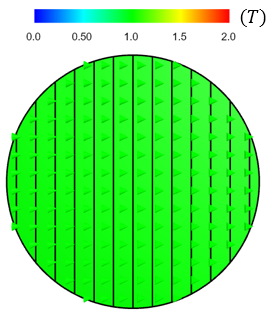

On en déduit immédiatement $\mu_q^*$, qui vaut:

$$\mu_q^* = \left( \frac{\rho}{\mu_{fer}(\beta)} + \frac{1-\rho}{\mu_0} \right)^{-1} $$

Il n'y a donc pas de différence fondamentale avec le cas linéaire, si ce n'est que $\mu_q^*$ dépend désormais de $\beta$ selon le modèle de fer considéré.

## 3) Champ dans l'axe $d$

Les matériaux sont en parallèle dans l'axe $d$, la perméabilité s'écrit donc :
$$ \mu_d^* = \rho \mu_{fer}(b_{fer}) + (1-\rho) \mu_0$$

Le champ moyen $\beta$ est imposé, mais est différent du champ local dans le fer et dans l'air. En particulier, le fer concentre le flux : son induction locale $b_{fer}$ sera plus important que $b_{air}$, ce qui va avoir tendance à le **saturer**, comme sur la figure suivante.

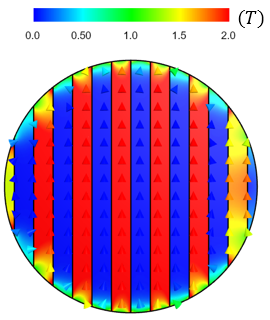


### a) Calcul des champs locaux

On suppose qu'on se situe loin des bords : le champ est supposé homogène dans chacun des matériaux. Le théorème d'Ampère et l'égalité au champ moyen $\beta$ permettent d'obtenir le système non-linéaire suivant:

$$\begin{bmatrix}
\dfrac{1}{\mu_{fer}(b_{fer})} & -\dfrac{1}{\mu_0} \\
\rho & 1-\rho
\end{bmatrix} \begin{bmatrix} b_{fer} \\ b_{air} \end{bmatrix} = \begin{bmatrix} 0 \\ \beta \end{bmatrix}$$ 

Le problème est que les variables de ces systèmes sont les inductions magnétiques $b$, pas les champs magnétiques $h$ qu'on a défini au début. Il faut donc passer par de l'interpolation.

In [4]:
# Définition des fonctions réciproques (en fonction de B et pas H)
Hlist = np.append(np.logspace(1,7,10000000),1e300)
Blist = b(Hlist)
muferlist = Blist/Hlist
muferlist = np.insert(muferlist,0,muferlist[0])
Blist = np.insert(Blist,0,0)

def H(B):
    return np.interp(B, Blist, Hlist)

def mufer(B):
    return np.interp(B, Blist, muferlist)

In [5]:
### Déclaration des systèmes à résoudre

def systeme_NL(B,beta,rho):
    return [ B[0]/mufer(B[0]) - B[1]/mu0, 1e7*rho*B[0] + 1e7*(1-rho)*B[1]  - 1e7*beta]

def systeme_lineaire(B,beta,rho):
    return [ B[0]/(mu_r0*mu0) - B[1]/mu0, 1e7*rho*B[0] + 1e7*(1-rho)*B[1]  - 1e7*beta]

In [6]:
## Calcul des champs locaux en fonction de beta et rho

allBeta = np.logspace(-6,-1,10)
allBeta = np.concatenate([allBeta[0:-1],np.linspace(0.1,2.499,200),np.linspace(2.5,3,100)], axis = 0)
allRho = np.logspace(-6,-2,100);
allRho = np.concatenate([allRho[0:-1],np.linspace(0.01,0.699,200),np.linspace(0.7,1,200)], axis = 0)

allBairNL = np.zeros([len(allBeta),len(allRho)])
allBferNL = np.zeros([len(allBeta),len(allRho)])
allBairL = np.zeros([len(allBeta),len(allRho)])
allBferL = np.zeros([len(allBeta),len(allRho)])
mud_homogeneise = np.zeros([len(allBeta),len(allRho)])

options = {'gtol': 1e-10, 'xtol':1e-10, 'ftol': 1e-10, 'maxiterint': 1000}

for i, beta in enumerate(allBeta):
    guess = [0.1,0.1]
    for j, rho in enumerate(allRho):
        allBferNL[i,j], allBairNL[i,j] = root(lambda x: systeme_NL(x,beta,rho),guess,
                                              tol=1e-10, method = 'lm',options = options)['x']
        allBferL[i,j] = beta / ((1-rho) / mu_r0 + rho)
        allBairL[i,j] = beta / ((1-rho) + rho * mu_r0)
        #allBferL[i,j], allBairL[i,j] = root(lambda x: systeme_lineaire(x,beta,rho),[0.1,0.1],
                                            #tol=1e-10, method = 'lm')['x']   
        guess = [allBferNL[i,j],allBairNL[i,j]]
    clear_output(wait = True)
    print(f'Calcul en cours ... {np.round(i/(len(allBeta)-1)*100,1)} %')
        

Calcul en cours ... 100.0 %


### b) Comparaisons des champs dans le fer non-linéaire vs linéaire
En ce qui concerne $\mu_d^*$ (en formulation duale), il faut bien faire la distinction entre le *champ moyen* $\beta$ et le champ local dans le fer $b_{fer}$. Ce dernier est systématiquement supérieur au champ dans l'air et peut parfois atteindre des valeurs très importantes. En particulier, plus la fraction volumique $\rho$ est faible, plus l'effet de **concentration du flux** est important, que la saturation viendra limiter. La différence avec un comportement linéaire (en pointillé sur la figure ci-dessous) est alors très marquée.

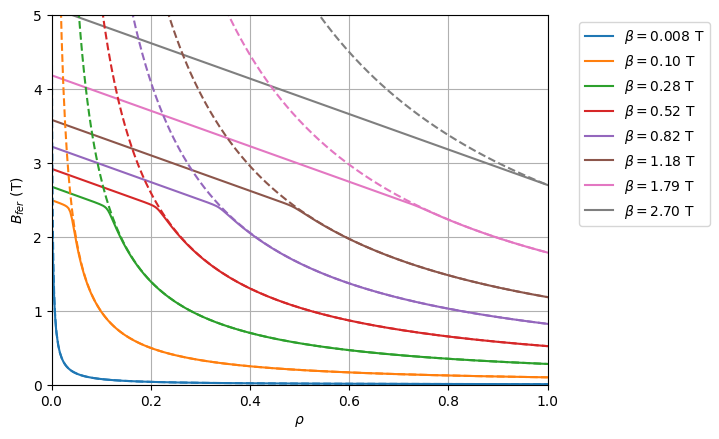

In [7]:
# Tracé du champ local dans le fer pour plusieurs champs moyens

plt.figure()
sel = np.array([8,10,25,45,70,100,150,250])-1
plt.plot(allRho,allBferNL[sel,:].transpose()) # en non-linéaire
plt.gca().set_prop_cycle(None)
plt.plot(allRho,allBferL[sel,:].transpose(),'--') # en linéaire
plt.axis([0,1,0,5])
plt.grid()
plt.xlabel('$\\rho$')
plt.ylabel('$B_{fer}$ (T)')
plt.legend(['$\\beta = 0.008$ T','$\\beta = 0.10$ T','$\\beta = 0.28$ T',
           '$\\beta = 0.52$ T','$\\beta = 0.82$ T','$\\beta = 1.18$ T',
            '$\\beta = 1.79$ T','$\\beta = 2.70$ T'],
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 3) Calcul de la compliance
Une fois les champs locaux connus, on peut calculer $\mu_d^*$ et en déduire les valeurs des différences de compliance. On remarque qu'en linéaire, cette différence de compliance est maximale pour une fraction volumique fixée, qui ne dépend que de $\mu_{fer}$. Ce n'est plus le cas en non-linéaire. Sans surprise, on remarque que les performances atteignables en linéaire sont supérieures à celles du non-linéaire.

In [8]:
muq_NL = 1/(allRho.reshape([1,len(allRho)])/mufer(allBeta.reshape([len(allBeta),1])) + (1-allRho.reshape([1,len(allRho)]))/mu0)
muq_L = 1/(allRho.reshape([1,len(allRho)])/(mu_r0*mu0) + (1-allRho.reshape([1,len(allRho)]))/mu0)

mud_NL = allRho.reshape([1,len(allRho)])*mufer(allBferNL) + (1-allRho.reshape([1,len(allRho)]))*mu0
mud_L = allRho.reshape([1,len(allRho)])*(mu_r0*mu0) + (1-allRho.reshape([1,len(allRho)]))*mu0

Jd_NL = np.pi/2 * allBeta.reshape([len(allBeta),1])**2 / mud_NL 
Jq_NL = np.pi/2 * allBeta.reshape([len(allBeta),1])**2 / muq_NL 
J_NL = Jd_NL - Jq_NL

Jd_L = np.pi/2 * allBeta.reshape([len(allBeta),1])**2 / mud_L 
Jq_L = np.pi/2 * allBeta.reshape([len(allBeta),1])**2 / muq_L 
J_L = Jd_L - Jq_L

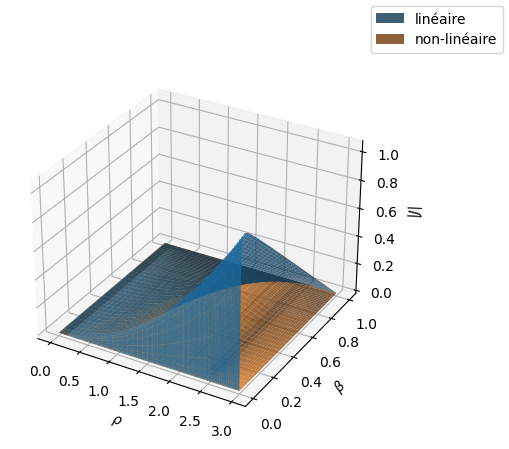

In [9]:
# Tracés

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b, r = np.meshgrid(allBeta, allRho )
surf1 = ax.plot_surface(b, r, -J_L.transpose(), label = 'linéaire', alpha= 0.8)
surf2 = ax.plot_surface(b, r, -J_NL.transpose(), label = 'non-linéaire', alpha= 0.8)

ax.set_xlabel('$\\rho$')
ax.set_ylabel('$\\beta$')
ax.set_zlabel('$|J|$')

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d
surf2._edgecolors2d = surf2._edgecolor3d
surf2._facecolors2d = surf2._facecolor3d
fig.legend()
plt.show()

## 4) Détermination de la fraction massique optimale en non-linéaire

 Comme en non-linéaire, cette valeur n'est pas constante, la fraction volumique optimale dépend de l'induction. Comme on a toujours $\mu_{fer} > \mu_0$, le champ local dans le fer sera toujours plus important que dans l'air ; ceci a notamment pour conséquence que $b_{fer} > \beta$, ce que traduit la cassure de la courbe du champ local tracé ci-dessous.

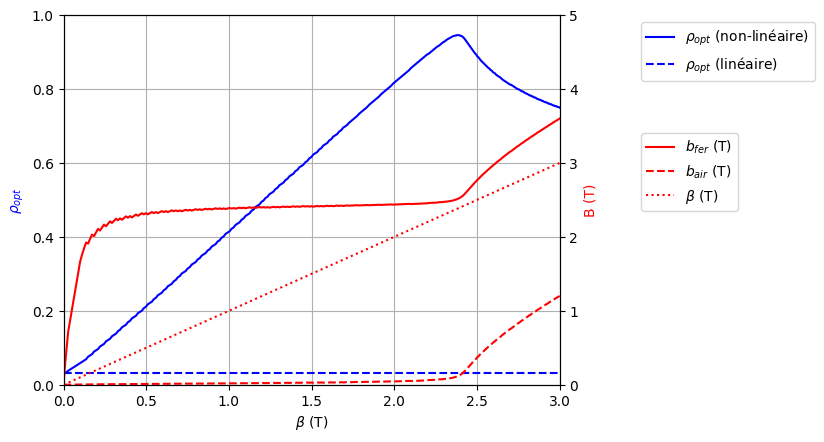

In [10]:
index = J_NL.argmin(axis=1)
rho_optNL = allRho[index]
rho_optL = allRho[J_L.argmin(axis=1)]
Bfer_opt = np.zeros(allBferNL.shape[0])
Bair_opt = np.zeros(allBairNL.shape[0])

for i in range(allBferNL.shape[0]):
    Bfer_opt[i] = allBferNL[i,index[i]]
    Bair_opt[i] = allBairNL[i,index[i]]
# Tracés  
    
fig, ax1 = plt.subplots()
plt.grid()
ax2 = ax1.twinx()
ax1.plot(allBeta,rho_optNL, 'b', label = '$\\rho_{opt}$ (non-linéaire)')
ax1.plot(allBeta,rho_optL, 'b--', label = '$\\rho_{opt}$ (linéaire)')
ax2.plot(allBeta,Bfer_opt, 'r', label = '$b_{fer}$ (T)')
ax2.plot(allBeta,Bair_opt, 'r--', label = "$b_{air}$ (T)")
ax2.plot(allBeta,allBeta, 'r:', label = "$\\beta$ (T)")
ax2.set_ylabel('B (T)', color='r')
ax1.set_ylabel('$\\rho_{opt}$', color='b')
ax1.set_xlabel('$\\beta$ (T)')
ax1.legend(bbox_to_anchor=(1.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.15, 0.7), loc='upper left')
ax1.axis([0,3,0,1])
ax2.axis([0,3,0,5])
plt.show()

## 5) Analyses supplémentaires

### a) Tracé de la différence des réluctivité homogénéisées
En formulation duale, on impose le flux par des conditions de Newton : il faut alors maximiser la différence des réluctivités, qui s'écrit:

$$(\mu_q^*)^{-1} - (\mu_d^*)^{-1}  = \left(\rho \mu_{fer}(b_{fer}) + (1-\rho) \mu_0 \right)^{-1}  - \left ( \frac{\rho}{\mu_{fer}(\beta)} + \frac{1-\rho}{\mu_0} \right) $$

En linéaire, $\mu_{fer}$ est constante, donc on n'a pas besoin de calculer les champs locaux. On peut directement annuler la dérivée de cette expression, et on trouve une expression qui dépend uniquement de la perméabilité relative du fer $\mu_r$:
$$ \rho_{opt} = \frac{1}{\sqrt{\mu_{r}} +1} $$

En non-linéaire, le niveau d'induction rentre aussi en compte.

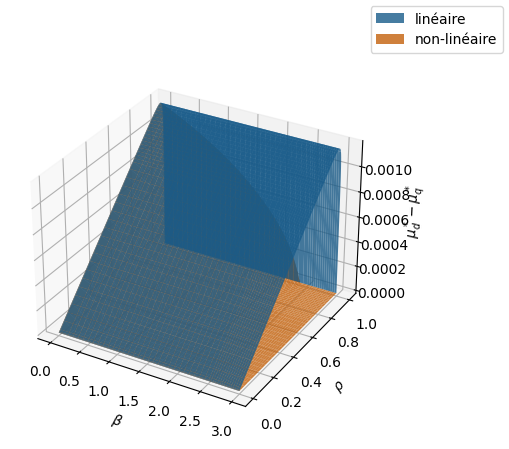

In [11]:
## Différence des perméabilités


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b, r = np.meshgrid(allBeta, allRho)
surf1 = ax.plot_surface(b, r, mud_L.transpose() - muq_L.transpose(), label = 'linéaire', alpha= 0.8)
surf2 = ax.plot_surface(b, r, mud_NL.transpose()- muq_NL.transpose(), label = 'non-linéaire', alpha= 0.8)

ax.set_xlabel('$\\beta$')
ax.set_ylabel('$\\rho$')
ax.set_zlabel('$\mu_d^* - \mu_q^*$')

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d
surf2._edgecolors2d = surf2._edgecolor3d
surf2._facecolors2d = surf2._facecolor3d
fig.legend()
plt.show()

### b) Tracé du rapport des perméabilités homogénéisées
On préfère parfois optimiser le *rapport de saillance*, c'est-à-dire le rapport des réluctivités, qui s'écrit :

$$ \frac{\mu_d^*}{\mu_q^*} = \frac{\frac{\rho}{\mu_{fer}} + \frac{1-\rho}{\mu_0} }{\rho \mu_{fer} + (1-\rho) \mu_0 }  $$

La dérivée de cette fonction (ainsi que celle de son inverse) s'annule en :
$$\rho_{opt} = 0.5$$

Pour ce type de problème, la **nature des matériaux n'a pas d'importance** tant qu'ils sont linéaires. On remarque cependant que ces résultats sont incompatibles avec ceux de la section précédente : ces deux fonctions sont différentes!

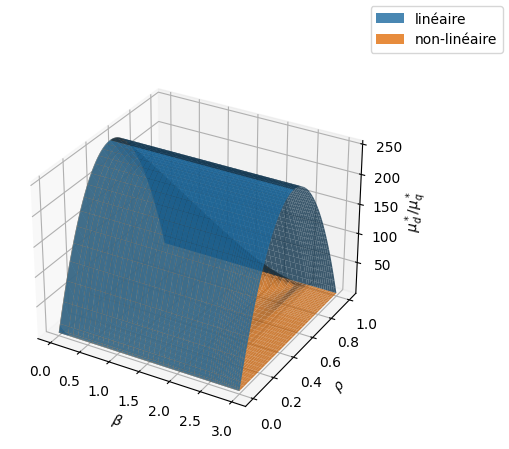

In [12]:
## Rapport des perméabilités

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
b, r = np.meshgrid(allBeta, allRho)
surf1 = ax.plot_surface(b, r, mud_L.transpose()/muq_L.transpose(), label = 'linéaire', alpha= 0.8)
surf2 = ax.plot_surface(b, r, mud_NL.transpose()/muq_NL.transpose(), label = 'non-linéaire', alpha= 0.8)

ax.set_xlabel('$\\beta$')
ax.set_ylabel('$\\rho$')
ax.set_zlabel('$\mu_d^* / \mu_q^*$')

surf1._edgecolors2d = surf1._edgecolor3d
surf1._facecolors2d = surf1._facecolor3d
surf2._edgecolors2d = surf2._edgecolor3d
surf2._facecolors2d = surf2._facecolor3d
fig.legend()
plt.show()